# Chest X-Ray Pneumonia Classification

#### Importing Required Files

In [1]:
import os
import random
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

#### Downloading the Train and Test Data

In [2]:
# Downloading the train data into temporary storage
!wget --no-check-certificate https://archive.org/download/pneumonia_chest_xray/train.zip -O /tmp/train.zip

# Downloading the validation data into temporary storage
!wget --no-check-certificate https://archive.org/download/pneumonia_chest_xray/val.zip -O /tmp/val.zip

# Downloading the test data into temporary storage
!wget --no-check-certificate https://archive.org/download/pneumonia_chest_xray/test.zip -O /tmp/test.zip

--2021-07-09 10:58:17--  https://archive.org/download/pneumonia_chest_xray/train.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia903405.us.archive.org/24/items/pneumonia_chest_xray/train.zip [following]
--2021-07-09 10:58:19--  https://ia903405.us.archive.org/24/items/pneumonia_chest_xray/train.zip
Resolving ia903405.us.archive.org (ia903405.us.archive.org)... 207.241.230.195
Connecting to ia903405.us.archive.org (ia903405.us.archive.org)|207.241.230.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145345857 (1.1G) [application/zip]
Saving to: ‘/tmp/train.zip’

/tmp/train.zip      100%[===================>]   1.07G   512KB/s    in 28m 57s 

2021-07-09 11:27:16 (644 KB/s) - ‘/tmp/train.zip’ saved [1145345857/1145345857]

--2021-07-09 11:27:16--  https://archive.org/download/pneumonia_chest_xray/val.zip
Resol

#### Extracting the Train and Test Data Zip Files

In [3]:
# Extracting the train data
local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# Extracting the validation data
local_zip = '/tmp/val.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Extracting the test data
local_zip = '/tmp/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#### Getting Directory Paths for Each Class

In [4]:
# Setting up class directories for training data
normal_dir = '/tmp/train/NORMAL'
pneumonia_dir = '/tmp/train/PNEUMONIA'

# Printing number of images in each class
print('Total training normal images: ', len(os.listdir(normal_dir)))
print('Total training pneumonia images: ', len(os.listdir(pneumonia_dir)))

# Getting list of image names for each class
normal_files = os.listdir(normal_dir)
pneumonia_files = os.listdir(pneumonia_dir)

Total training normal images:  1341
Total training pneumonia images:  3875


#### Printing Image for Each Class for Given Index

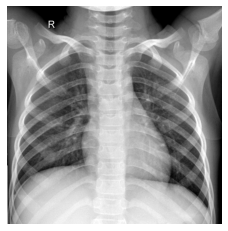

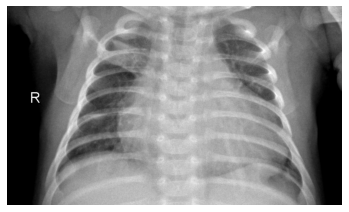

In [5]:
# Getting a valid random index between 0 and 1341
image_index = random.randint(0, 1340)

# Creating the image directories for the index for each class
next_normal = os.path.join(normal_dir, normal_files[image_index])
next_pneumonia = os.path.join(pneumonia_dir, pneumonia_files[image_index])

# Plotting the images for both classes
for img_path in [next_normal, next_pneumonia]:
  img = mpimg.imread(img_path)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

#### Setting up Image Data Generators for Training and Validation Data

In [6]:
# Fixing batch size
BATCH_SIZE = 32

In [8]:
# Setting up train directory and its ImageDataGenerator
TRAINING_DIR = '/tmp/train'
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40, 
    zoom_range = 0.2,
    vertical_flip = True,
    fill_mode= 'nearest',
    validation_split = 0.2
)

# Setting up test directory and its ImageDataGenerator
TEST_DIR = '/tmp/test'
test_datagen = ImageDataGenerator(rescale = 1./255)

# Setting up training generator using flow_from_directory
training_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (299, 299),
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
    subset = 'training'
)

# Setting up validation generator using flow_from_directory
validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (299, 299),
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

# Setting up validation test using flow_from_directory
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (299, 299),
    class_mode = None,
    batch_size = 1
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Setting up the Deep Neural Network Structure

In [10]:
# Defining the neural network model structure
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3), padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 149, 149, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 149, 149, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 149, 149, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0

In [11]:
# Fixing some required parameters
num_epochs = 10
steps_per_epoch = training_generator.n // training_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

In [12]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Setting up callback function for reducing learning rate when validation loss stops reducing
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')

In [13]:
# Training the model on train set and validating it on validation set
history = model.fit(training_generator, epochs=num_epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, 
                    validation_steps=validation_steps, callbacks=[lr_reduce], verbose=1)

Epoch 1/10
130/130 [==============================] - 203s 1s/step - loss: 0.3395 - accuracy: 0.8464 - val_loss: 1.0707 - val_accuracy: 0.7402
Epoch 2/10
130/130 [==============================] - 170s 1s/step - loss: 0.2935 - accuracy: 0.8756 - val_loss: 0.9408 - val_accuracy: 0.7422
Epoch 3/10
130/130 [==============================] - 170s 1s/step - loss: 0.2631 - accuracy: 0.8882 - val_loss: 0.6570 - val_accuracy: 0.7432

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
130/130 [==============================] - 173s 1s/step - loss: 0.2233 - accuracy: 0.9181 - val_loss: 1.1025 - val_accuracy: 0.7393
Epoch 5/10
130/130 [==============================] - 171s 1s/step - loss: 0.2111 - accuracy: 0.9203 - val_loss: 0.3336 - val_accuracy: 0.9082
Epoch 6/10
130/130 [==============================] - 172s 1s/step - loss: 0.1902 - accuracy: 0.9278 - val_loss: 0.2454 - val_accuracy: 0.9170

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.0

#### Plotting Training and Validation Accuracies and Loss Functions

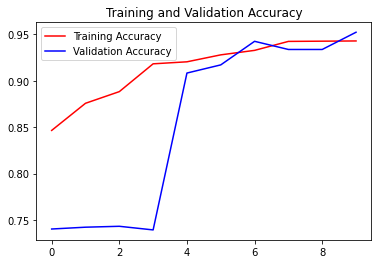

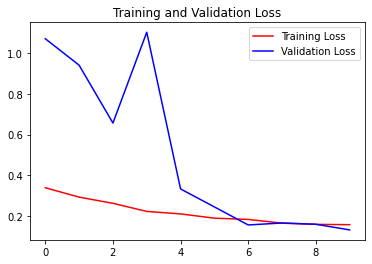

In [14]:
# Getting training and validation accuracies and losses
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Getting number of epochs
epochs = range(len(acc))

# Plotting the accuracy graphs
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.show()

# Plotting the loss functions
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.show()

#### Saving the Trained Model

In [15]:
# Saving the trained model 
model.save('saved_model/my_model')

# Convert folder to zip and download
!zip -r /content/file.zip /content/saved_model
files.download("/content/file.zip")

INFO:tensorflow:Assets written to: saved_model/my_model/assets
  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 90%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 74%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 94%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>